This tutorial demonstrates how to use `ncpi` to compute field potentials from simulations of leaky integrate-and-fire (LIF) network models. To achieve accurate extracellular potentials, we have integrated some of the most recent methods available for this purpose.

Two main strategies are available:

1. **Proxy-based methods**
   Estimate field potentials using measurable variables from point-neuron simulations (e.g., synaptic currents or population firing rates).

2. **Kernel-based methods**
   Dynamically adapt to each model by incorporating the known spatial distribution of cells and synapses, recurrent connectivity, and biophysical membrane properties.

In this tutorial, we will explore both approaches in detail.

**Note:** To run this notebook, the [NEST simulator](https://nest-simulator.readthedocs.io/) must be installed. You can install a pre-built NEST package with:

```
conda install -c conda-forge nest-simulator=3.8
```

Similarly, to compute field potentials using the kernel method, the [`LFPykernels`](https://github.com/LFPy/LFPykernels)
package must be installed via pip:

```
pip install LFPykernels
```

---

We will simulate the **Hagen’s LIF network model** using the ground-truth parameters identified as the best fit in the original publication.

The root directory containing the model description is:
`ncpi/examples/simulation/Hagen_model/simulation/`

The **network parameters** (e.g., neuron model, connectivity, and synapses) are defined in:
`params/network_params.py`

The **simulation parameters** (e.g., duration, time step, threading) are defined in:
`params/simulation_params.py`. These include:
- Total simulation time: **12000 ms**
- Time step: **2⁻⁴ ms**
- Number of threads: **32** (for parallel processing)

To simulate a different network or change the simulation configuration, you can modify the corresponding entries in these parameter files.

The script that creates and runs the LIF network using **NEST**, and collects and saves simulation output variables, is:
`python/simulation.py`

In [1]:
import ncpi

# Create the Simulation object
sim = ncpi.Simulation(param_folder='../../examples/simulation/Hagen_model/simulation/params',
                      python_folder='../../examples/simulation/Hagen_model/simulation/python',
                      output_folder='../../examples/simulation/Hagen_model/simulation/output')

# Load the network and simulate it
sim.network('network.py', 'network_params.py')
sim.simulate('simulation.py', 'simulation_params.py')


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: May  5 2025 12:50:25

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.


Jun 05 12:18:05 correlation_detector [Info]: 
    Default for delta_tau changed from 0.03125 to 0.3125 ms

Jun 05 12:18:05 correlomatrix_detector [Info]: 
    Default for delta_tau changed from 0.03125 to 0.3125 ms

Jun 05 12:18:05 correlospinmatrix_detector [Info]: 
    Default for delta_tau changed from 0.00625 to 0.0625 ms

Jun 05 12:18:05 SimulationManager::set_status [Info]: 
    Tics per ms and resolution changed from 1000 tics and 0.1 ms to 16000 tics
    and 0.0625 ms.
Creating population E, tau_syn_ex = 0.5, tau_syn_in = 0.5
 Creating population I, tau_syn_ex = 0.5, tau_syn_in = 0.5
 Connecting E with E with weight 1.589
 Connecting E with I with weigh

The following variables from the simulation are saved to file: spike times, neuron IDs, the simulation time step, and total simulation duration. To record additional variables—such as synaptic currents—you will need to modify the `python/simulation.py` file.

In [2]:
import os
import pickle

# Load spike times
with open(os.path.join('../../examples/simulation/Hagen_model/simulation/output', 'times.pkl'), 'rb') as f:
    times = pickle.load(f)

# Load gids
with open(os.path.join('../../examples/simulation/Hagen_model/simulation/output', 'gids.pkl'), 'rb') as f:
    gids = pickle.load(f)

# Load dt
with open(os.path.join('../../examples/simulation/Hagen_model/simulation/output', 'dt.pkl'), 'rb') as f:
    dt = pickle.load(f)

# Load tstop
with open(os.path.join('../../examples/simulation/Hagen_model/simulation/output', 'tstop.pkl'), 'rb') as f:
    tstop = pickle.load(f)

We begin by demonstrating how to use the kernel method. To start, load the `KernelParams` class from the `analysis_params.py` script. This class defines the morphologies, network connectivity, and other biophysical properties of the multicompartment neuron network model.

In [3]:
from examples.simulation.Hagen_model.simulation.params.analysis_params import KernelParams

Only retain simulated data recorded after the transient period. This period is specified in the `KernelParams` class.

In [4]:
P_X=['E', 'I']
transient = KernelParams.transient

for X in P_X:
    gids[X] = gids[X][times[X] >= transient]
    times[X] = times[X][times[X] >= transient]

We will now create the spatiotemporal filter kernel, which will be used to compute the current dipole moment (CDM). We define the kernel's biophysical properties using a *quasi-active* linearized model of the Ih-type channel (`set_Ih_linearized_hay2011`). The passive reversal potential (`e_pas`) is adjusted to ensure a uniform resting membrane potential at `Vrest` via the `make_cell_uniform` function. To use other biophysical properties, you can modify the `biophys` list accordingly (please refer to the `LFPykernels` documentation for available options).

In addition, we must provide the following paths to the `create_kernel` method:
- `output_path`: the path to pre-simulated outputs from the multicompartment neuron network model
- `multicompartment_neuron_network_path`: the path containing neuron morphologies and mechanisms

In [5]:
# Pre-simulated outputs from the multicompartment neuron network model
output_path = os.path.join('/DATA/multicompartment_neuron_network', 'output', 'adb947bfb931a5a8d09ad078a6d256b0')

# Path to the data files of the multicompartment neuron models
multicompartment_neuron_network_path = '/DATA/multicompartment_neuron_network'

# Create the FieldPotential object and compute the kernel
potential = ncpi.FieldPotential()
biophys = ['set_Ih_linearized_hay2011', 'make_cell_uniform']
H_YX = potential.create_kernel(multicompartment_neuron_network_path,
                               output_path,
                               KernelParams,
                               biophys,
                               dt,
                               tstop,
                               electrodeParameters=None,
                               CDM=True)

The CDM-based kernel is stored in the `KernelApproxCurrentDipoleMoment` probe. We use this probe to compute the CDM for all combinations of excitatory and inhibitory populations (E and I) in the network by convolving the spike rates with the kernel.

In [6]:
import numpy as np
import scipy.signal as ss

def get_spike_rate(times, transient, dt, tstop):
    """
    Compute the spike rate from spike times.

    Parameters
    ----------
    times : array
        Spike times.
    transient : float
        Transient time at the start of the simulation.
    dt : float
        Simulation time step or bin size.
    tstop : float
        Simulation stop time.

    Returns
    -------
    bins : array
        Time bins.
    hist : array
        Spike rate.
    """
    bins = np.arange(transient, tstop + dt, dt)
    hist, _ = np.histogram(times, bins=bins)
    return bins, hist.astype(float)

# Define the probe to compute the CDM
probe = 'KernelApproxCurrentDipoleMoment'
CDM_data = dict(EE=[], EI=[], IE=[], II=[])

for X in P_X:
    for Y in P_X:
        # Compute the firing rate
        bins, spike_rate = get_spike_rate(times[X], transient, dt, tstop)
        # Pick only the z-component of the CDM kernel
        kernel = H_YX[f'{X}:{Y}'][probe][2, :]
        # CDM
        sig = np.convolve(spike_rate, kernel, 'same')
        CDM_data[f'{X}{Y}'] = ss.decimate(sig,q=10,zero_phase=True)

We will now compare the kernel approach with a proxy-based method. Specifically, we will use a simple firing rate (FR) proxy. We will only consider the firing rate of the excitatory cell population, based on the assumption that it contributes most strongly to the generation of extracellular potentials. Firing rates will be computed using `dt` as the bin size, although other commonly used bin sizes—typically 1, 10, or 50 ms—can also be applied.

In [11]:
# Compute firing rates of excitatory cells
bins, spike_rate_E = get_spike_rate(times['E'], transient, dt, tstop)
FR = spike_rate_E.reshape(1, -1)

# Create a FieldPotential object
fp = ncpi.FieldPotential(kernel = False)

# Get the field potential proxy
proxy = fp.compute_proxy(method = 'FR', sim_data = {'FR': FR}, sim_step = None)
proxy = ss.decimate(proxy,q=40,zero_phase=True)

Let's plot the results of the kernel and proxy methods. We will visualize the spike trains, firing rates, and the computed CDM and proxy values over a specific time interval.

Text(0.5, 0, 't (ms)')

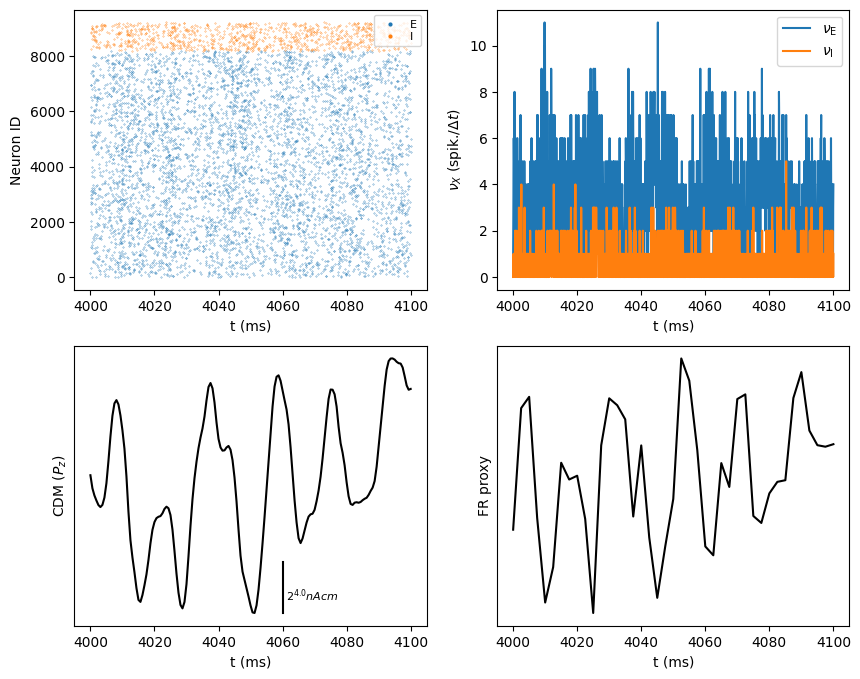

In [12]:
import matplotlib.pyplot as plt

# Create a figure
fig, axes = plt.subplots(2, 2, figsize=(10,8))

# Time interval
T = [4000, 4100]

# Colors for the raster plot of the spike trains
colors = ['#1f77b4', '#ff7f0e']

# Raster plot of the spike trains
ax = axes[0,0]
for i,X in enumerate(P_X):
    t = times[X]
    gi = gids[X]
    ii = (t >= T[0]) & (t <= T[1])
    ax.plot(t[ii], gi[ii], '.', color = colors[i], markersize=0.5)
    ax.set_ylabel('Neuron ID')

# Legend
for j, Y in enumerate(P_X):
    ax.plot([], [], '.', color = colors[j], label=f'{Y}', markersize=4)
ax.legend(loc=1, fontsize=8, labelspacing=0.2)
ax.set_xlabel('t (ms)')
ax.axis('tight')

# Firing rates
ax = axes[0,1]

for i,X in enumerate(P_X):
    # Compute the firing rate
    bins, spike_rate = get_spike_rate(times[X], transient, dt, tstop)
    # Plot the firing rate
    bins = bins[:-1]
    ii = (bins >= T[0]) & (bins <= T[1])
    ax.plot(bins[ii], spike_rate[ii], color='C{}'.format(i),label=r'$\nu_\mathrm{%s}$' % X)
ax.legend(loc=1)
ax.set_ylabel(r'$\nu_X$ (spik./$\Delta t$)')
ax.set_xlabel('t (ms)')
ax.axis('tight')

# CDMs
ax = axes[1,0]

CDM = CDM_data['EE'] + CDM_data['EI'] + CDM_data['IE'] + CDM_data['II']
bins = np.arange(transient, tstop, dt)
bins = bins[::10]  # to take into account the decimate ratio
ii = (bins >= T[0]) & (bins <= T[1])
ax.plot(bins[ii], CDM[ii], color='k')

# Labels and limits
ax.set_ylabel(r'CDM ($P_z$)')
ax.set_yticks([])
ax.set_xlabel('t (ms)')
ax.axis('tight')

# Add scale
y_max = np.max(CDM[ii])
y_min = np.min(CDM[ii])
scale = (y_max - y_min) / 5
ax.plot([T[0]+60,T[0]+60], [y_min + scale, y_min], 'k')
ax.text(T[0] + 61, y_min + scale/4., r'$2^{%s}nAcm$' % np.round(np.log2(scale*10**(-4))), fontsize=8)

# Proxy
ax = axes[1,1]

bins = np.arange(transient, tstop, dt)
bins = bins[::40]  # to take into account the decimate ratio
ii = (bins >= T[0]) & (bins <= T[1])
ax.plot(bins[ii],-proxy[ii], color='k')

ax.set_yticks([])
ax.set_ylabel('FR proxy')
ax.set_xlabel('t (ms)')